# Movie Sentiment Prediction Using Glove Word Embeddings

## Imports

In [0]:
import numpy as np
import os

## Download IMDB Raw Dataset

In [2]:
## keras provides the processed Imdb dataset as list of word-indexes.
## We need to get the raw Imdb dataset
!wget --no-check-certificate http://mng.bz/0tIo

--2020-01-21 08:57:17--  http://mng.bz/0tIo
Resolving mng.bz (mng.bz)... 35.166.24.88
Connecting to mng.bz (mng.bz)|35.166.24.88|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mng.bz/0tIo [following]
--2020-01-21 08:57:17--  https://mng.bz/0tIo
Connecting to mng.bz (mng.bz)|35.166.24.88|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 
Location: http://s3.amazonaws.com/text-datasets/aclImdb.zip [following]
--2020-01-21 08:57:17--  http://s3.amazonaws.com/text-datasets/aclImdb.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.98.163
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.98.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘0tIo.1’

0tIo.1              100%[===================>]  57.90M  29.1MB/s    in 2.0s    

2020-01-21 08:57:19 (29.1 MB/s) - ‘0tIo.1’ saved [60711700/60711

In [3]:
!unzip -q 0tIo

replace aclImdb/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
#!ls -l aclImdb/train/neg

## Read Imdb Dataset

In [0]:
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    #print(fname)
    if fname[-4:] == '.txt':
      #print('opening file', fname)
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In [6]:
print(len(labels))

25000


In [7]:
print(len(texts))

25000


## Tokenize the Imdb Reviews

In [0]:
%tensorflow_version 1.0

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # cuts off reviews after 100 words

# let's try 1000 words
#maxlen = 1000
training_samples = 8000 # train only on 8000 samples
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, but first shuffles the data because you're starting with data in which samples are ordered, all negatives first, then all positives
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
 

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [9]:
print(len(x_train))
print(len(y_train))
print(y_train.shape)
print(len(x_val))
print(len(y_val))

8000
8000
(8000,)
10000
10000


## Download Glove Pre Trained Embeddings

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-21 08:59:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-21 08:59:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-21 08:59:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [11]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [12]:
!ls

0tIo	 glove.6B.100d.txt  glove.6B.50d.txt  __MACOSX
0tIo.1	 glove.6B.200d.txt  glove.6B.zip      pre_trained_glove_model.h5
aclImdb  glove.6B.300d.txt  glove.6B.zip.1    sample_data


## Read Pre Trained Glove Embeddings

In [13]:
glove_dir = '/content'

# build the dictionary to store word -> embedding info.
embeddings_index = {}

# use 400K words, 50 dimension pre trained glove embeddings
#embedding_dim = 50
#embedding_file_name = 'glove.6B.50d.txt'

# use 400K words, 100 dimension pre trained glove embeddings
embedding_dim = 100
embedding_file_name = 'glove.6B.100d.txt'

f = open(os.path.join(glove_dir, embedding_file_name ))

# read the embedding entries 
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [14]:
print(list(embeddings_index.keys())[0:50])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after']


In [15]:
print(embeddings_index['the'])
print(len(embeddings_index['the']))

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

## Prepare Glove word-embeddings matrix

For each word from the word_index (from tokenizer), get the Glove Embeddings for that word and build the embedding matrix.
Note that we are considering only the limited number of words (max_words = 10000)

In [0]:
# build embedding matrix for the words in our reviews
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            #Words not found in the embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

## Define Model

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Load the Glove Embeddings in the Model

In [18]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Train the model

In [19]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val)
                    )

model.save_weights('pre_trained_glove_model.h5')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 3s 348us/step - loss: 0.6779 - acc: 0.6035 - val_loss: 0.6110 - val_acc: 0.6797
Epoch 2/10
8000/8000 [==============================] - 2s 309us/step - loss: 0.5583 - acc: 0.7194 - val_loss: 0.6103 - val_acc: 0.6676
Epoch 3/10
8000/8000 [==============================] - 2s 283us/step - loss: 0.4830 - acc: 0.7706 - val_loss: 0.6020 - val_acc: 0.6864
Epoch 4/10
8000/8000 [==============================] - 2s 262us/step - loss: 0.4178 - acc: 0.8098 - val_loss: 0.6307 - val_acc: 0.6889
Epoch 5/10
8000/8000 [==============================] - 2s 265us/step - loss: 0.3768 - acc: 0.8344 - val_loss: 0.6269 - val_acc: 0.6988
Epoch 6/10
8000/8000 [==============================] - 2s 261us/step - loss: 0.3248 - acc: 0.8589 - val_loss: 0.6602 - val_acc: 0.6928
Epoch 7/10
8000/8000 [===============

## Plot the result

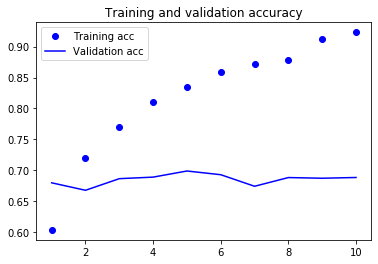

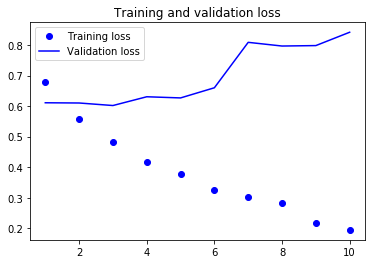

In [20]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()